In [1]:
import numpy as np
from pathlib import Path
import glob2
import matplotlib.pyplot as plt

from src.visualization.visualization_fct import mask_to_rgb

path = '../data/raw/carseg_data/clean_data/'

In [2]:
all_paths = [ Path(p).absolute() for p in glob2.glob(path + '*') ]
print('Number of files:', len(all_paths))
assert len(all_paths) == 3521

Number of files: 3521


In [3]:
all_files = [np.load(f) for f in all_paths]

In [4]:
# total number of classes? 9

all_len_classes = [len(list(set(a[3].flatten()))) for a in all_files]

print('Max nb of distinct classes:', max(all_len_classes))

Max nb of distinct classes: 9


In [5]:
all_stems = np.array([f.stem for f in all_paths])

# test set
test_ids = np.loadtxt('../references/test_set_ids.txt', dtype=str)
test_stems = np.array([f.split('.')[0] for f in test_ids])
test_paths = np.array(all_paths)[np.isin(all_stems, test_stems)]
test_files = np.array(all_files)[np.isin(all_stems, test_stems)]
print('Test set:', test_ids)

Test set: ['0_a.jpg' '1_a.jpg' '2_a.jpg' '3_a.jpg' '5_a.jpg' '6_a.jpg' '10_a.jpg'
 '11_a.jpg' '12_a.jpg' '19_a.jpg' '20_a.jpg' '21_a.jpg' '22_a.jpg'
 '24_a.jpg' '26_a.jpg' '28_a.jpg' '29_a.jpg' '32_a.jpg' '33_a.jpg'
 '35_a.jpg' '36_a.jpg' '39_a.jpg' '40_a.jpg' '43_a.jpg' '45_a.jpg'
 '46_a.jpg' '47_a.jpg' '50_a.jpg' '51_a.jpg' '52_a.jpg']


[0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Shape img: (256, 256, 3)


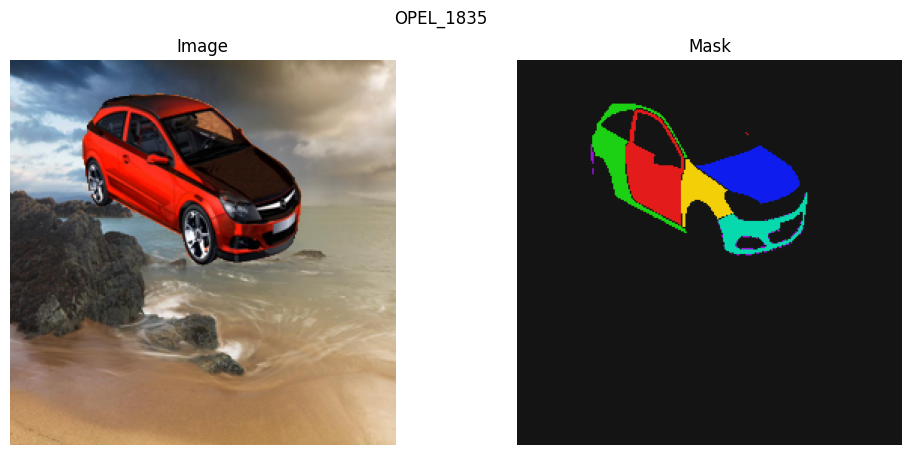

In [6]:
index = np.random.randint(len(all_files))
img_ex = all_files[index]

labels_in_img = list(set(img_ex[3].flatten()))
print(labels_in_img)

anImage = (np.transpose(img_ex[:3], (1, 2, 0))*255).astype(int)
print('Shape img:', anImage.shape)

plt.figure(figsize=(12,5), facecolor='white')
plt.suptitle(all_paths[index].stem)

plt.subplot(1,2,1)
plt.title('Image')
plt.imshow(anImage) 
plt.axis(False)

plt.subplot(1,2,2)
plt.title('Mask')
plt.imshow(mask_to_rgb(img_ex[3]), cmap='jet')
plt.axis(False)

plt.show()